## Fit the eclipse in  CHEOPSim simulated dataset 

In [1]:
%pylab inline
from pycheops import Dataset
from uncertainties import ufloat
from pycheops.constants import R_SunN, c

Populating the interactive namespace from numpy and matplotlib


### Create and instance of the dataset

There are 3 ways to load a dataset

1. For authorized DACE users: By specifying the file_key for the dataset. The data will be obtained from the .zip file if it has already downloaded and saved in your pycheops data cache directory. If the .zip file does not exist, the data will be downloaded from DACE and cached. 
```python
>>> dataset = Dataset('CH_PR900048_TG001701_V0000')
```

2. Download an example data set, e.g., 
```python
>>> dataset = Dataset.from_test_data('DP-080', target='EBLM J0113+31')
```

3. Download the simulated data from CHEOPsim ftp site using the run number, e.g., 
```python
>>> dataset = Dataset.from_simulation(7798, target='EBLM J0113+31')
```

**N.B.** CHEOPsim output is removed from the FTP server after some time so option 3 may not work for old simulations.

In [2]:
#dataset=Dataset.from_test_data('DP-080', target='EBLM J0113+31')
#dataset = Dataset.from_simulation(7798, target='EBLM J0113+31')
dataset = Dataset('CH_PR900048_TG001701_V0000', target='EBLM J0113+31')

_ = dataset.get_lightcurve(aperture='OPTIMAL')

Found archive tgzfile /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000.tgz
 PI name     : CHEOPSim
 OBS ID      : 7798
 Target      : EBLM J0113+31
 Coordinates : 01:13:51.33 +31:49:10.1
 Spec. type  : G0
 V magnitude : 10.06 +- 0.00
Light curve data loaded from  /Users/pflm/pycheops_data/CH_PR900048_TG001701_V0000-OPTIMAL.fits
Time stored relative to BJD = 2459128
Aperture radius used = 30 arcsec
Mean counts = 10091662.8
Median counts = 10091105.2
RMS counts = 5478.1 [543 ppm]
Median standard error = 3261.6 [323 ppm]


### Least-squares fit

Light curve for the eclipse of a planet/star of radius $R_p$ by a star of radius $R_s$.
The depth of the eclipse is L. The geometry of the system is defined by the properties of the transit, as follows.

- T_0:   time of mid-transit (BJD relative to dataset.bjd_ref)
- P:     orbital period (days)
- D:     transit depth, $(R_p/R_s)^2 = k^2$
- W:     transit width, $(R_s/a)\sqrt{(1+k)^2 - b^2}/\pi$
- b:     impact parameter, $a\cos(i)/R_s$
- L:     Eclipse depth
- a_c:   Light time travel across the orbit (days)
- c:     flux scaling factor
- f_c:   $\sqrt{e}\cos(\omega)$  (N.B. $\omega$ for primary star's orbit).
- f_s:   $\sqrt{e}\sin(\omega)$

Parameters and their bounds/priors are  specified as follows.

- as a floating point number for fixed parameters, e.g., "P=1.234".
- as a tuple for a free parameter with bounds, e.g., "L = (1e-6,0.1)" or "c = (0.9, 1.0, 1.1)". The median value of the tuple is used as the initial value in the fit.
- as a ufloat floating-point value with a standard error, e.g., "P=ufloat(1.2345,0.0001)", to specify a free parameter with a Gaussian prior.
- as an lmfit Parameter, e.g., "lmfit.Parameter(value=0.01,min=0.001,max=0.1,vary=True)"

Trends in the data can be modelled using decorrelation against the following parameters:
 - linear or quadratic decorrelation against position (dfdx, dfdy, df2dx2, d2fdxdy, d2fdx2, d2fdy2);
 - decorrelation against roll angle (dfdsinphi, dfdcosphi, dfdsin2phi, dfdcos2phi);
 - linear or quadratic time trend (dfdt, d2fdt2).
 
In this example we are using decorrelation against roll angle.


The output from this method is an lmfit [MinimizerResult](https://lmfit.github.io/lmfit-py/fitting.html#minimizerresult-the-optimization-result) object.

The eclipse does not contain information on the parameters D, P, etc. so we fix these parameters in the fit or constrain them by priors.
 

In [3]:
BJD_0 = 2456023.26988
P = 14.2769001
E = round((dataset.bjd_ref-BJD_0)/P)
T_0 = ufloat(BJD_0 + P*E - dataset.bjd_ref,0.0002)
D = 0.02300
W = 0.01890391
b = 0.299
f_c = 0.08707092 
f_s = -0.54974417 
a_c = 25.808*R_SunN/c/86400  # Light travel time across the orbit in days

result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c,                             
                               dfdsinphi=(-1,1),dfdcosphi=(-1,1))
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 989
    # variables        = 5
    chi-square         = 1785.83102
    reduced chi-square = 1.81486892
    Akaike info crit   = 594.444420
    Bayesian info crit = 618.927891
    RMS residual       = 434.7 ppm
[[Variables]]
    T_0:       -6.64279533 +/- 2.6910e-04 (0.00%) (init = -6.642798)
    P:          14.2769 (fixed)
    D:          0.023 (fixed)
    W:          0.01890391 (fixed)
    b:          0.299 (fixed)
    L:          2.5732e-04 +/- 3.3071e-05 (12.85%) (init = 0.05005)
    f_c:        0.08707092 (fixed)
    f_s:       -0.5497442 (fixed)
    c:          1.00016872 +/- 2.0133e-05 (0.00%) (init = 1)
    a_c:        0.0006931734 (fixed)
    dfdsinphi:  3.8443e-04 +/- 1.7259e-05 (4.49%) (init = 0)
    dfdcosphi: -1.1208e-04 +/- 3.1870e-05 (28.43%) (init = 0)
    k:          0.15165751 +/- 0.00000000 (0.00%) == 'sqrt(D)'
    aR:         18.7270014 +/- 0.00000000 (0.00%) == '

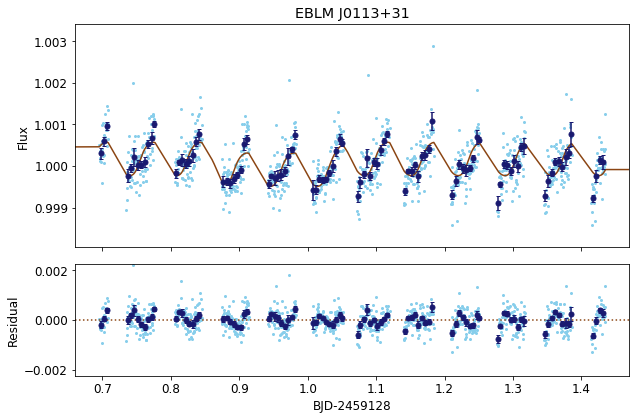

In [4]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12,binwidth=0.005)


#### Residuals v. roll angle.
 The plot above shows trends in the residuals that seem to be periodic. We can check this using `rollangle_plot()`. 

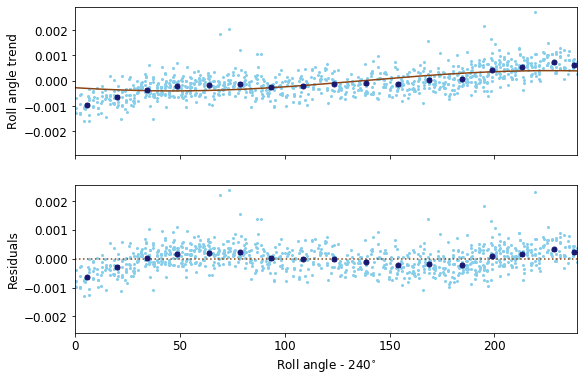

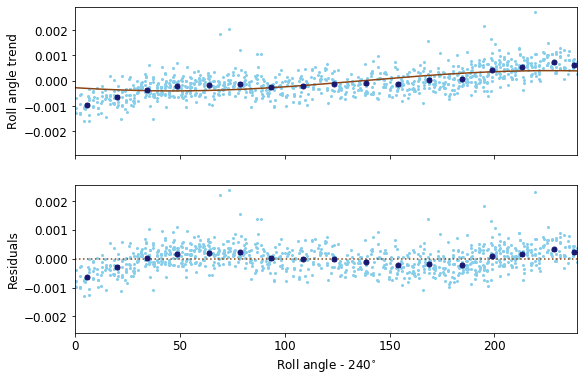

In [5]:
dataset.rollangle_plot(figsize=(9,6),fontsize=12)

#### Re-fit with additional detrending
 The fit to the trend with roll angle is not very good so try adding decorrelation against $\sin(2\phi)$ and $\cos(2\phi)$.    
 
 There are also some obvious outliers so we clip those out here.

In [6]:
_=dataset.clip_outliers()


Rejected 6 points more than 5.0 x MAD = 1387 ppm from the median


In [7]:
result = dataset.lmfit_eclipse(T_0=T_0, P=P, D=D, W=W, b=b, L=(0.0001,0.1),
                               f_c=f_c, f_s=f_s, a_c= a_c,                             
                               dfdsinphi=(-1,1),dfdcosphi=(-1,1),
                               dfdsin2phi=(-1,1),dfdcos2phi=(-1,1))
print(dataset.lmfit_report())

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 983
    # variables        = 7
    chi-square         = 1203.83206
    reduced chi-square = 1.23343449
    Akaike info crit   = 213.210861
    Bayesian info crit = 247.445125
    RMS residual       = 358.0 ppm
[[Variables]]
    T_0:        -6.64280077 +/- 2.2176e-04 (0.00%) (init = -6.642798)
    P:           14.2769 (fixed)
    D:           0.023 (fixed)
    W:           0.01890391 (fixed)
    b:           0.299 (fixed)
    L:           2.9522e-04 +/- 2.7437e-05 (9.29%) (init = 0.05005)
    f_c:         0.08707092 (fixed)
    f_s:        -0.5497442 (fixed)
    c:           1.00003512 +/- 3.1938e-05 (0.00%) (init = 1)
    a_c:         0.0006931734 (fixed)
    dfdsinphi:   5.1411e-04 +/- 1.6429e-05 (3.20%) (init = 0)
    dfdcosphi:   9.6231e-05 +/- 5.1350e-05 (53.36%) (init = 0)
    dfdsin2phi: -3.2747e-04 +/- 1.9820e-05 (6.05%) (init = 0)
    dfdcos2phi: -1.6165e-04 +/- 3.2733e-05 (

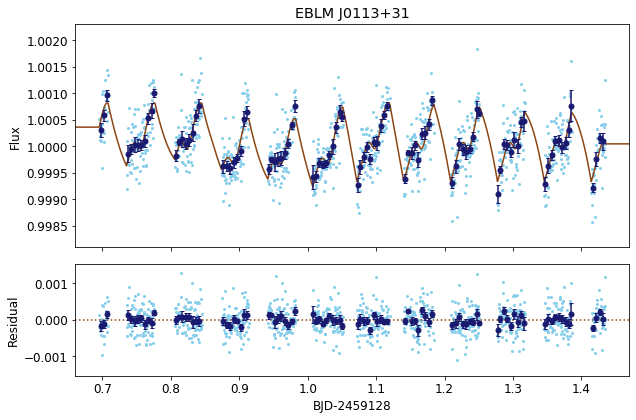

In [8]:
fig = dataset.plot_lmfit(title=dataset.target,figsize=(9,6),fontsize=12, binwidth=0.005)

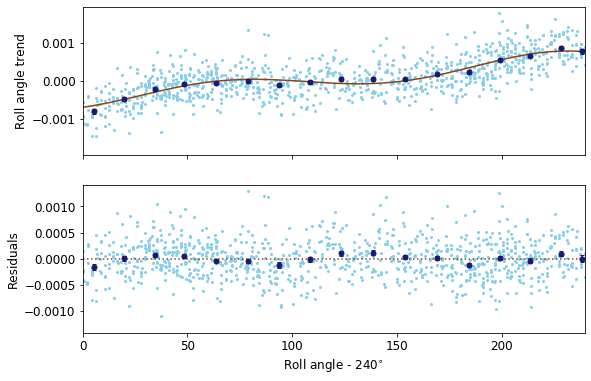

In [9]:
fig = dataset.rollangle_plot(figsize=(9,6),fontsize=12)

Residuals look better, the coefficients have values > 10x their errors and the [BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion) is reduced by more than 200, so clearly justified to include these extra terms.

#### Plot fit with roll-angle trends removed


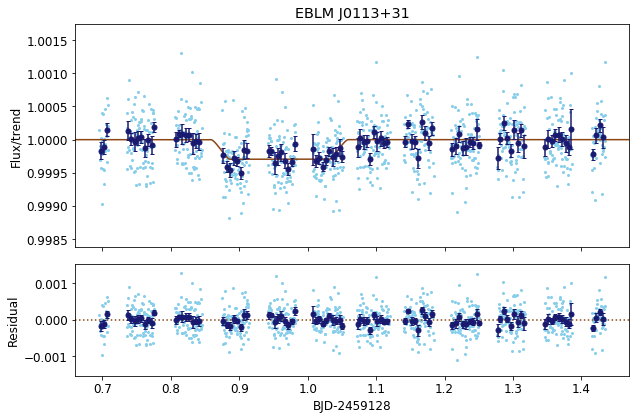

In [10]:
fig = dataset.plot_lmfit(title=dataset.target, detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005)


### Sampling the posterior
Sampling the posterior probability distribution using the affine-invariant sampler [emcee](https://emcee.readthedocs.io/en/stable/). 

The $\pm$1-sigma limits on parameters from the prior are indicated in the corner plot using dashed lines.

This return value from emcee_transit is an instance of an [EnsembleSampler](https://emcee.readthedocs.io/en/latest/user/sampler/) object.

In [11]:
sampler = dataset.emcee_sampler()
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 256/256 [02:03<00:00,  2.08it/s]

Running sampler ..



100%|██████████| 512/512 [03:22<00:00,  2.53it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 32768
    # data points      = 982
    # variables        = 8
    chi-square         = 1204.30638
    reduced chi-square = 1.23645419
    Akaike info crit   = -12789.5830
    Bayesian info crit = -12750.4663
    RMS residual       = 358.0 ppm
[[Variables]]
    T_0:        -6.64281182 +/- 1.9912e-04 (0.00%) (init = -6.642798)
    P:           14.2769 (fixed)
    D:           0.023 (fixed)
    W:           0.01890391 (fixed)
    b:           0.299 (fixed)
    L:           2.9535e-04 +/- 2.4904e-05 (8.43%) (init = 0.05005)
    f_c:         0.08707092 (fixed)
    f_s:        -0.5497442 (fixed)
    c:           1.00003463 +/- 3.3568e-05 (0.00%) (init = 1)
    a_c:         0.0006931734 (fixed)
    dfdsinphi:   5.1512e-04 +/- 1.6428e-05 (3.19%) (init = 0)
    dfdcosphi:   9.3957e-05 +/- 5.3252e-05 (56.68%) (init = 0)
    dfdsin2phi: -3.2718e-04 +/- 1.8767e-05 (5.74%) (init = 0)
    dfdcos2phi: -1.6316e-04 +/- 3.4519e-0

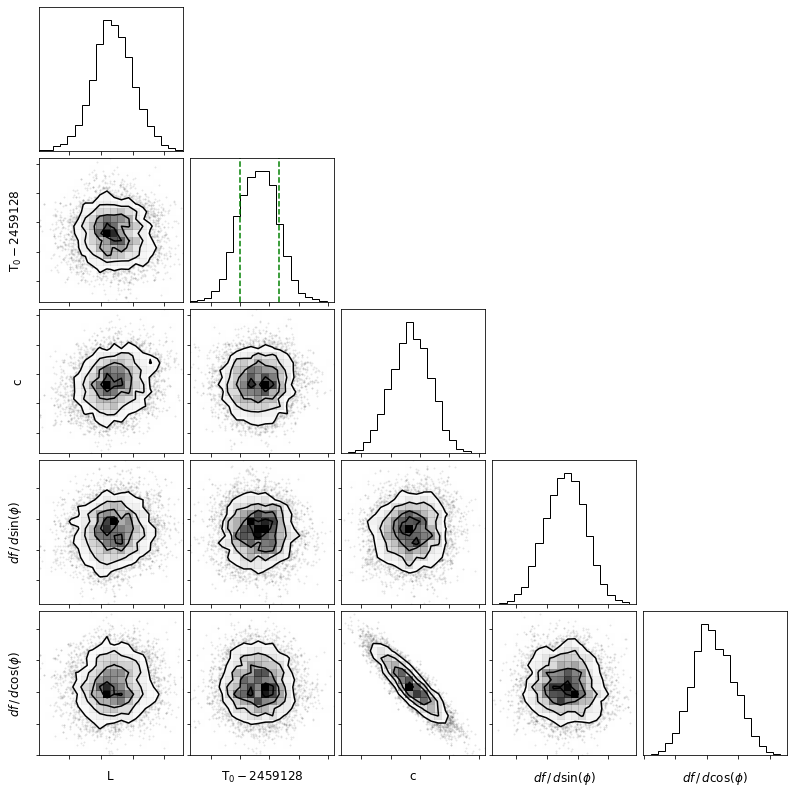

In [12]:
cornerplot = dataset.corner_plot(['L','T_0','c','dfdsinphi','dfdcosphi'])

#### Plot fit with position/roll-angle trends removed

The plot routine returns a matplotlib [Figure](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.figure.Figure.html#matplotlib.figure.Figure) object so you can, for example, use `fig.savefig("plot.png")` so save the image to a file.

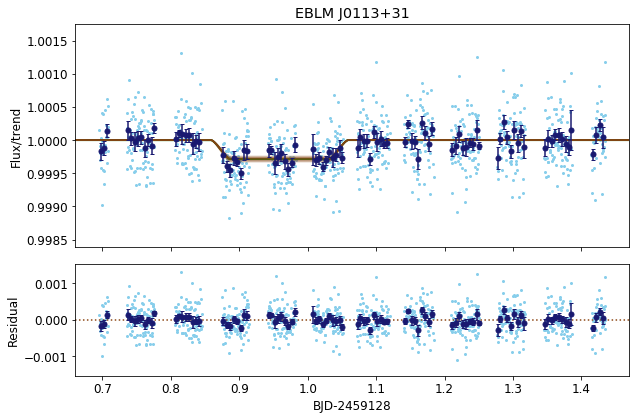

In [13]:
fig = dataset.plot_emcee(title=dataset.target,detrend=True,
                         figsize=(9,6),fontsize=12, binwidth=0.005)

### Add correlated noise

Now use "add_shoterm=True" so that correlated noise is modelled using the SHOTerm kernel from [celerite](https://celerite.readthedocs.io/en/stable/). By default the parameter quality factor is fixed at $Q=1/\sqrt{2}$ so that the kernel is the one commonly used to model granulation noise
$$ k(\tau) = \omega_0 e^{-\omega_0\tau/\sqrt{2}}\cos\left(-\omega_0\tau/\sqrt{2} - \pi/4\right)$$

Broad priors on log_sigma, log_omega0 and log_S0 from a previous run of this sampler without priors are used here to remove long tails in the distrubtions with very few samples  that mess up the plots.


In [14]:
sampler = dataset.emcee_sampler(add_shoterm=True,
                                log_sigma=(-11,-7), log_omega0=(3.5,7.5), log_S0=(-30,-20),
                                steps=100, nwalkers=100, burn=1000, thin=10)
print(dataset.emcee_report())

Running burn-in ..


100%|██████████| 1000/1000 [08:20<00:00,  2.00it/s]

Running sampler ..



100%|██████████| 1000/1000 [07:56<00:00,  2.10it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 100000
    # data points      = 982
    # variables        = 10
    chi-square         = 1205.08256
    reduced chi-square = 1.23979687
    Akaike info crit   = -12789.7016
    Bayesian info crit = -12740.8057
    RMS residual       = 358.1 ppm
[[Variables]]
    T_0:        -6.64279580 +/- 2.0570e-04 (0.00%) (init = -6.642798)
    P:           14.2769 (fixed)
    D:           0.023 (fixed)
    W:           0.01890391 (fixed)
    b:           0.299 (fixed)
    L:           2.9605e-04 +/- 3.0224e-05 (10.21%) (init = 0.05005)
    f_c:         0.08707092 (fixed)
    f_s:        -0.5497442 (fixed)
    c:           1.00003205 +/- 3.3373e-05 (0.00%) (init = 1)
    a_c:         0.0006931734 (fixed)
    dfdsinphi:   5.1381e-04 +/- 1.7551e-05 (3.42%) (init = 0)
    dfdcosphi:   1.0282e-04 +/- 5.3897e-05 (52.42%) (init = 0)
    dfdsin2phi: -3.2787e-04 +/- 2.1278e-05 (6.49%) (init = 0)
    dfdcos2phi: -1.6343e-04 +/- 3.4886

#### Trail plot
A trail plot is shows the parameter values v. step number for all the walkers in the sampler. This is a very effective way to check that the sampler has converged, i.e., that the sampler is randomly sampling the posterior probability distribution.

In a "well-mixed" chain, the trail plot will look like noise for all the walkers and there will be no trends in the position or width of the trails.


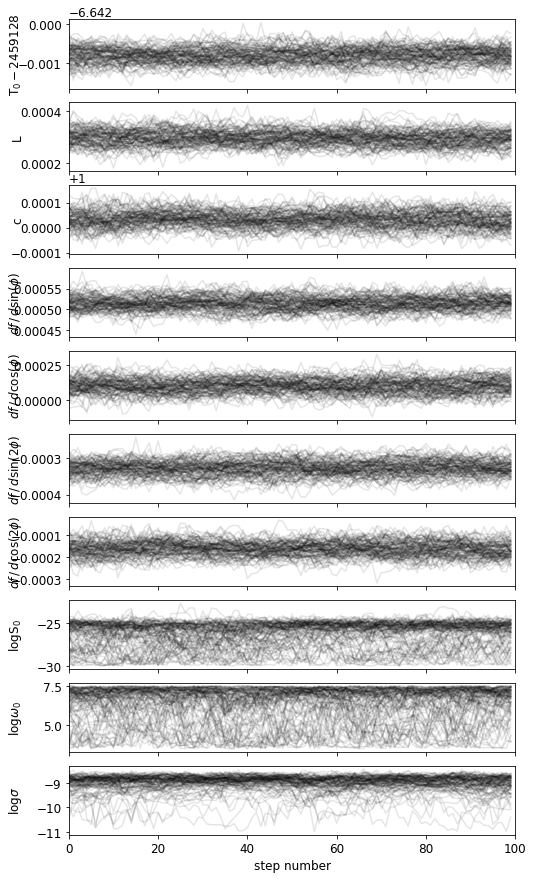

In [15]:
fig = dataset.trail_plot('all')

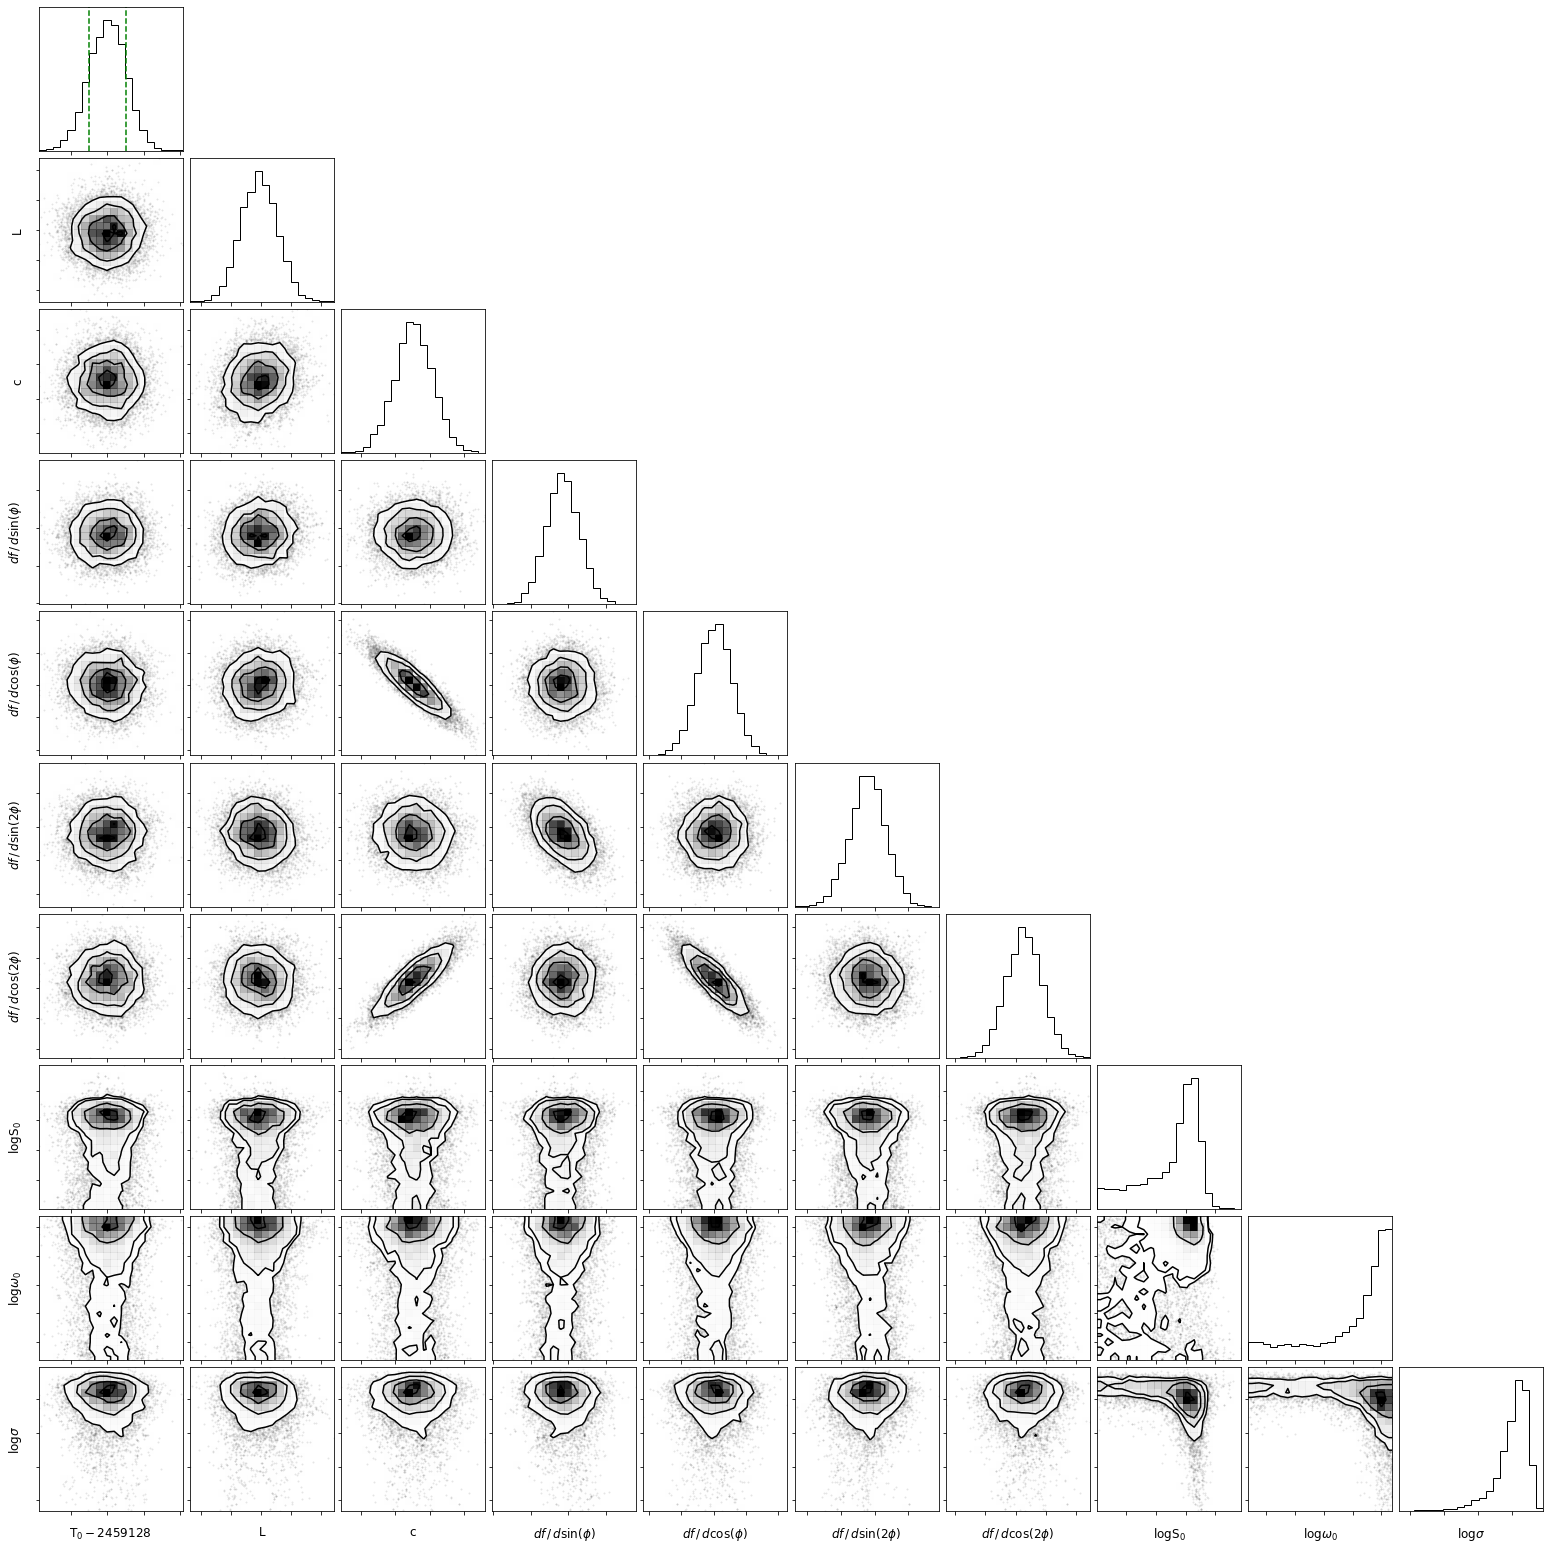

In [16]:
cornerplot = dataset.corner_plot('all')

#### Light curve fit with trends removed
Light curve fits for nsamples parameter sets from from the sampled posterior distribution are plotted together with the best-fit light curve model.

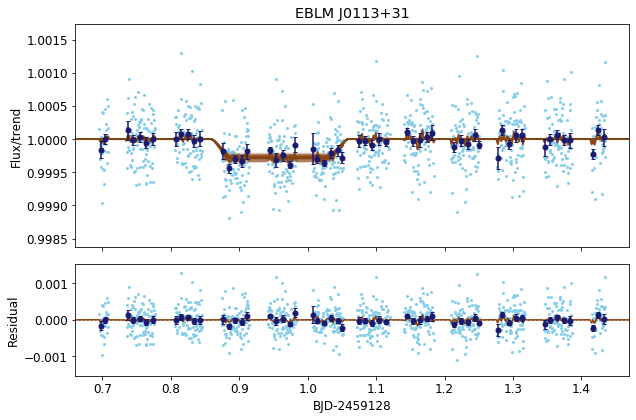

In [17]:
fig = dataset.plot_emcee(title=dataset.target,detrend=True, nsamples=100,
                         figsize=(9,6),fontsize=12)

(c) 2020 Pierre Maxted, Keele Univerity, UK